In [27]:
#export PYTHONPATH=PATH_TO_YOUR_setup.py_file



In [1]:
#pip3 install --upgrade pip
#pip3 install shap
#pip3 install xgboost


import shap
from datetime import datetime
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer








In [2]:
file_path = "/Users/dongwon-ryu/PycharmProjects/pythonProject/PythonDataWorkspace/TFR/저출산/"

In [3]:
plt.rc('font', family='NanumGothic') 
plt.rcParams['font.family'] = "NanumGothic"
plt.rcParams['axes.unicode_minus'] = False


In [4]:
#전처리
def preprocess(raw_data) :

    raw_data = raw_data.transpose()

    # 1년 shift ex) 2022 출산율을 2021년 데이터가 예측하도록!
    raw_data[0] = raw_data[0].shift(-1)
    raw_data.iloc[0, 0] = '(y) 전국출산율 대비 지역출산율'

    # 남성, 여성 실업률 데이터 삭제
    raw_data = raw_data.drop(raw_data.columns[[14, 15]], axis='columns')
    
    ##### 뉴스 첫 번째 칼럼의 index = 16 ####
    # 뉴스&커뮤니티 데이터 미사용
    #raw_data = raw_data.drop(raw_data.columns[[16, 17, 18, 19, 20, 21]], axis='columns')
    # 뉴스&커뮤니티 ver1 데이터만 사용
    #raw_data = raw_data.drop(raw_data.columns[[18, 19, 20, 21]], axis='columns')
    # 뉴스&커뮤니티 ver2 데이터만 사용
    raw_data = raw_data.drop(raw_data.columns[[16, 17, 19, 21]], axis='columns')
    # 뉴스&커뮤니티 ver3 데이터만 사용
    #raw_data = raw_data.drop(raw_data.columns[[16, 17, 18, 20]], axis='columns')

    raw_data.rename(columns=raw_data.iloc[0],inplace=True)
    data = raw_data.drop(raw_data.index[0])
    #data.iloc[:,1:]
    columns = data.columns[1:]

    data = data.drop([])
    #for j in columns :
        #j_1 = j +'lag_1'
        #j_2 = j +'lag_2'
        #j_3 = j +'lag_3'
        #data[j_1] = data[j].shift(1)
        #data[j_2] = data[j].shift(2)
        #data[j_3] = data[j].shift(3)
    data=data.dropna(axis=0)
    return data


In [5]:

# 학습 데이터와 테스트 데이터 분리 
def preprocess_split(data) : 
    train_set, test_set = train_test_split(data, test_size=0.2, random_state=rand, shuffle=True)
    train_X = train_set.iloc[:,1:]
    train_Y = train_set['(y) 전국출산율 대비 지역출산율']
    test_X = test_set.iloc[:,1:]
    test_Y = test_set['(y) 전국출산율 대비 지역출산율']
    return train_X, train_Y, test_X, test_Y


In [6]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

def NMAPE(y_test, y_pred):
    return 1 - np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

    

def MAE(y_test, y_pred): 
    return np.mean(abs(y_test - y_pred))

In [7]:
def multi_regression(train_X, train_Y, test_X, test_Y) : 
    print('########## Regression Model ##########\n')
    from sklearn.linear_model import LinearRegression
    columns_x = train_X.columns
    from sklearn.preprocessing import StandardScaler  
    from sklearn.pipeline import Pipeline

    scaler = StandardScaler()
            

    # 모델링
    model = LinearRegression()
    model.fit(train_X.values, train_Y)
    #print( "coefficient=", model.coef_ )
    #print( "intercept=", model.intercept_ )
    #print( "R²=", model.score(test_X, test_Y) )
    
    # 에러 계산
    some_predicted = model.predict(test_X)
    mse = mean_squared_error(some_predicted, test_Y)
    rmse = np.sqrt(mse)
    print('Multi Regression rmse', rmse)
    '''
    print('Multi Regression mse', mse)    
    mape = MAPE(test_Y, some_predicted)
    mae = MAE(test_Y, some_predicted)
    print('Multi Regression mape', mape)    
    print('Multi Regression mae', mae)
    '''
    
    # cross validation

    X = pd.concat([train_X, test_X])
    Y = pd.concat([train_Y, test_Y])
    kfold = KFold(n_splits=5, random_state=rand, shuffle=True)
    
    scores = cross_val_score(LinearRegression(), X, Y, cv=kfold,
                             scoring='neg_mean_squared_error') 
    rmse_scores = (-scores)**0.5
    print('cross-val-score \n{}'.format(rmse_scores))
    print('cross-val-score.mean \n{:.3f}\n'.format(rmse_scores.mean()))
    
    nmape_scorer = make_scorer(MAPE)
    mape_scores = cross_val_score(LinearRegression(), X, Y, cv=kfold, scoring=nmape_scorer)
    print('mape-score \n{}'.format(mape_scores))
    print('mape-score.mean \n{:.3f}\n'.format(mape_scores.mean()))

    # SHAP
    #explain = shap.KernelExplainer(model.predict, train_X)    
    #shap_values = explain.shap_values(train_X)
    #shap.summary_plot(shap_values, train_X.to_numpy(), feature_names=columns_x)
    
    return

In [15]:
def random_forest(train_X, train_Y, test_X, test_Y) : 
    
    print('########## Random Forest Model ##########')
    from sklearn.ensemble import RandomForestRegressor
    columns_x = train_X.columns
    
    # 모델링
    model = RandomForestRegressor(random_state=rand, max_depth=10, n_estimators=200)
    model.fit(train_X, train_Y)
    
    # 에러 계산
    some_predicted = model.predict(test_X)
    mse = mean_squared_error(some_predicted, test_Y)    
    rmse = np.sqrt(mse)
    print('Random Forest rmse', rmse)

    
    # cross validation
    X = pd.concat([train_X, test_X])
    Y = pd.concat([train_Y, test_Y])
    kfold = KFold(n_splits=5, random_state=rand, shuffle=True)
    scores = cross_val_score(RandomForestRegressor(random_state=rand, max_depth=10, n_estimators=200),
                             X, Y, cv=kfold, scoring='neg_mean_squared_error') 
    rmse_scores = (-scores)**0.5
    print('cross-val-score \n{}'.format(rmse_scores))
    print('cross-val-score.mean \n{:.3f}\n'.format(rmse_scores.mean()))

    
    nmape_scorer = make_scorer(MAPE)
    mape_scores = cross_val_score(RandomForestRegressor(random_state=rand, max_depth=10, n_estimators=200),
                            X, Y, cv=kfold, scoring=nmape_scorer)
    print('mape-score \n{}'.format(mape_scores))
    print('mape-score.mean \n{:.3f}\n'.format(mape_scores.mean()))

    # SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(train_X)
    shap.summary_plot(shap_values, train_X.to_numpy(), feature_names=columns_x)    
    #shap.dependence_plot(feature_names=column_x, shap_values, train_X, interaction_index=None, show=False)
    #shap.plots.partial_dependence(feature_names="사교육비", model=model)


    return


In [16]:
def xgboost(train_X, train_Y, test_X, test_Y) : 
    
    print('########## XGBoost Model ##########')
    columns_x=train_X.columns
    for j in columns_x : 
        train_X = train_X.astype({ j : 'float' })
        test_X = test_X.astype({ j : 'float' })
    train_Y = train_Y.astype({'(y) 전국출산율 대비 지역출산율' : 'float'})
    test_Y = test_Y.astype({'(y) 전국출산율 대비 지역출산율' : 'float'})

    # 모델링
    model = xgb.XGBRegressor(random_state=rand, learning_rate=0.05, max_depth=12, n_estimators=300)
    model.fit(train_X, train_Y)

    # 에러계산
    some_predicted = model.predict(test_X)
    mse = mean_squared_error(some_predicted, test_Y)
    rmse = np.sqrt(mse)    
    print('xgboost rmse', rmse)
    
    # cross validation
    X = pd.concat([train_X, test_X])
    Y = pd.concat([train_Y, test_Y])
    kfold = KFold(n_splits=5, random_state=rand, shuffle=True)
    scores = cross_val_score(xgb.XGBRegressor(random_state=rand, learning_rate=0.05, max_depth=12, n_estimators=300),
                             X, Y, cv=kfold, scoring='neg_mean_squared_error') 
    rmse_scores = (-scores)**0.5
    print('cross-val-score \n{}'.format(rmse_scores))
    print('cross-val-score.mean \n{:.3f}'.format(rmse_scores.mean()))
    print()
    nmape_scorer = make_scorer(MAPE)
    mape_scores = cross_val_score(xgb.XGBRegressor(random_state=rand, learning_rate=0.05, max_depth=12, n_estimators=300),
                            X, Y, cv=kfold, scoring=nmape_scorer)
    print('mape-score \n{}'.format(mape_scores))
    print('mape-score.mean \n{:.3f}\n'.format(mape_scores.mean()))

    
    #SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(train_X)
    #shap.summary_plot(shap_values, train_X.to_numpy(), feature_names=columns_x)
    shap.dependence_plot(train_X.columns[3], shap_values, train_X)
    shap.dependence_plot(train_X.columns[-4], shap_values, train_X)
    shap.dependence_plot(train_X.columns[-5], shap_values, train_X)
    shap.dependence_plot(train_X.columns[-6], shap_values, train_X)
    shap.dependence_plot(train_X.columns[-7], shap_values, train_X)   

    return
    

In [17]:
def svm(raw_data) : 
    print('########## SVC Model ##########')

    from sklearn.svm import SVR
    from sklearn.preprocessing import StandardScaler  
    from sklearn.pipeline import Pipeline
    scaler = StandardScaler()
    
    # 전처리
    X = raw_data.iloc[:,1:]
    columns_x = X.columns
    Y = raw_data['(y) 전국출산율 대비 지역출산율']
    
    # train set, test set 분리
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=rand, shuffle=True)        
    train_X = scaler.fit_transform(train_X)
    test_X = scaler.fit_transform(test_X)

    # 모델링
    model = SVR(C=0.4, epsilon=0.01, kernel='rbf')
    model.fit(train_X, train_Y)

    # 에러 계산
    some_predicted = model.predict(test_X)
    mse = mean_squared_error(some_predicted, test_Y)    
    rmse = np.sqrt(mse)
    print('svm rmse', rmse)
    
    # create pipeline & cross validation
    kfold = KFold(n_splits=5, random_state=rand, shuffle=True)
    pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                   ('model', SVR(C=0.4, epsilon=0.01, kernel='rbf'))])
    #gamma='scale',
    scores = cross_val_score(estimator=pipeline, X=X, y=Y, 
                             scoring='neg_mean_squared_error', cv=kfold, n_jobs=-1)
    nmape_scorer = make_scorer(MAPE)
    rmse_scores = (-scores)**0.5
    print('cross-val-score \n{}'.format(rmse_scores))
    print('cross-val-score.mean \n{:.3f}'.format(rmse_scores.mean()))
    print()
    nmape_scorer = make_scorer(MAPE)
    mape_scores = cross_val_score(estimator=pipeline, X=X, y=Y, 
                             scoring=nmape_scorer, cv=kfold, n_jobs=-1)
    print('mape-score \n{}'.format(mape_scores))
    print('mape-score.mean \n{:.3f}\n'.format(mape_scores.mean()))

    #SHAP
    #explainer = shap.KernelExplainer(model.predict, train_X)
    #shap_values = explainer.shap_values(train_X)
    #shap.summary_plot(shap_values, train_X, feature_names=columns_x)
    #train_X = pd.DataFrame(train_X, columns=columns_x)
    #shap.dependence_plot(train_X.columns[3], shap_values, train_X)
    #shap.dependence_plot(train_X.columns[-4], shap_values, train_X)
    #shap.dependence_plot(train_X.columns[-5], shap_values, train_X)
    #shap.dependence_plot(train_X.columns[-6], shap_values, train_X)
    #shap.dependence_plot(train_X.columns[-7], shap_values, train_X) 

    return
    

In [18]:
state = ['강원도', '경기도', '경상남도', '경상북도', '광주', '대구', '대전', '부산', '서울',  '울산', '인천', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도', '세종']
raw_data = pd.DataFrame()
rand = 31
for i in state :  
    data_1 = pd.read_csv(file_path+ i +'_Feature conclusion.csv', encoding='euc-kr',thousands = ',')
    data_1 = preprocess(data_1)
    raw_data = pd.concat([raw_data, data_1], axis=0)
#raw_data
#raw_data = raw_data.drop(raw_data.columns[0], axis=1)
#raw_data = raw_data.reset_index()
#raw_data = raw_data.drop(raw_data.columns[0], axis=1)
#raw_data.corr()








In [19]:
'''
import seaborn as sns

raw_data_ = raw_data.copy()
raw_data_ = raw_data_.iloc[:,1:]
raw_data_.columns

sns.heatmap(raw_data_.corr(), annot=True, cmap='coolwarm')
'''


"\nimport seaborn as sns\n\nraw_data_ = raw_data.copy()\nraw_data_ = raw_data_.iloc[:,1:]\nraw_data_.columns\n\nsns.heatmap(raw_data_.corr(), annot=True, cmap='coolwarm')\n"

########## Random Forest Model ##########
Random Forest rmse 0.05948722836368121
cross-val-score 
[0.05211719 0.04296502 0.07131136 0.0543215  0.05916091]
cross-val-score.mean 
0.056

mape-score 
[3.70247273 3.22256151 4.38505762 3.79873225 3.9202049 ]
mape-score.mean 
3.806



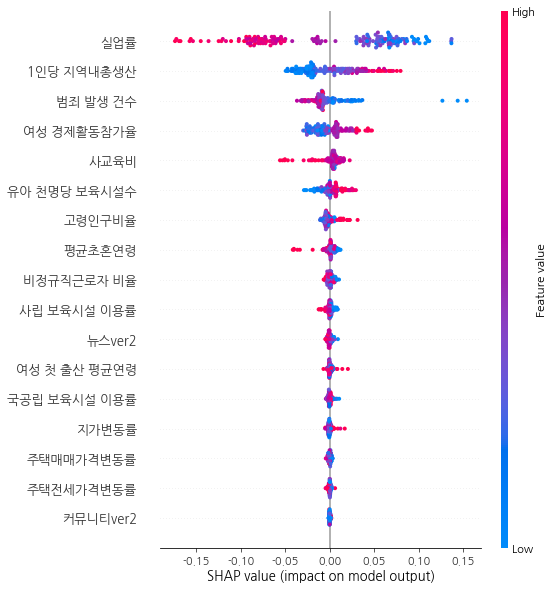

########## XGBoost Model ##########
xgboost rmse 0.05075131194296552
cross-val-score 
[0.05190252 0.04882053 0.04342162 0.05235033 0.05885693]
cross-val-score.mean 
0.051

mape-score 
[3.34892857 3.62345214 3.21019563 3.63536853 3.95689728]
mape-score.mean 
3.555



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


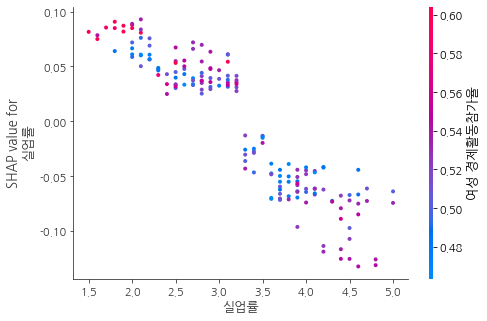

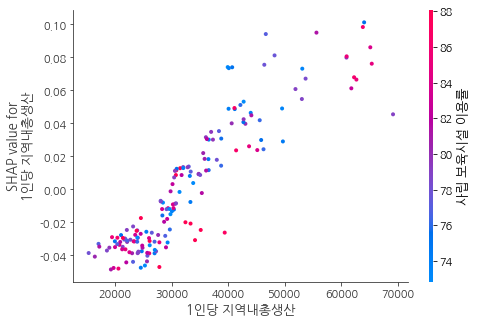

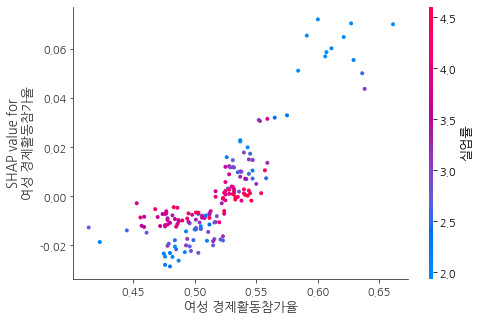

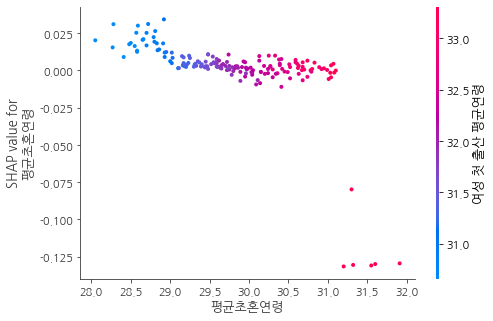

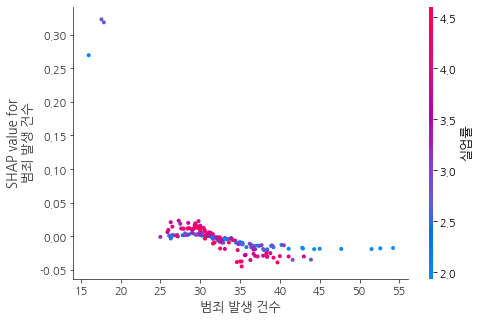

########## SVC Model ##########
svm rmse 0.05988010127938207
cross-val-score 
[0.05626447 0.0588249  0.08521411 0.05047491 0.05100293]
cross-val-score.mean 
0.060

mape-score 
[3.83729226 4.05237243 3.69897878 2.67222476 3.4233693 ]
mape-score.mean 
3.537



In [20]:
train_X, train_Y, test_X, test_Y = preprocess_split(raw_data)
shap.initjs()


#multi_regression(train_X, train_Y, test_X, test_Y)
random_forest(train_X, train_Y, test_X, test_Y)
xgboost(train_X, train_Y, test_X, test_Y)
svm(raw_data)

#now = datetime.now()
#file_time =now.strftime('%Y-%m-%d %H%M')
#pd_con = pd.concat([pd_Linear, pd_Rand, pd_xgb], axis =1)
#pd_con.to_csv(file_time+'result.csv')
